# 2) Analyze source collection and target file

This notebook includes the code to analyze the collection of sounds compiled in the previous notebook and that will be later used as the source collection in our audio mosaicing code. The notebook also contains the code to analyze the target audio file that will be later reconstructed using sound chunks from the source collection.

The audio analysis carried out in this notebook uses the Pythonn bindings of the Essentia library which was introduced in the first session of AMPLAB. Please make sure you checked the [Essentia Python tutorial](https://essentia.upf.edu/documentation/essentia_python_tutorial.html) to get familiarized with using Essentia in Python. Also useful is to always have a browser tab opened with Essentia's [Algorithms Reference](https://essentia.upf.edu/documentation/algorithms_reference.html) documentation page.

In [ ]:
# Essentia
!pip install essentia
# Freesound-python
!pip install git+https://github.com/mtg/freesound-python.git
# Mount drive and cd to notebook folder
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/SMC/AMPLab2425/AMPLAB 2025 Module 3 - Sound retrieval with Freesound and Creative Applications'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 48.7 MB/s eta 0:00:00
  Cloning https://github.com/mtg/freesound-python.git to /tmp/pip-req-build-aouj08xa
  Running command git clone --filter=blob:none --quiet https://github.com/mtg/freesound-python.git /tmp/pip-req-build-aouj08xa
  Resolved https://github.com/mtg/freesound-python.git to commit 5be99a3689d17303c01cb122bbb0d5a96eba04f6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for freesound-python: filename=freesound_python-1.1-py3-none-any.whl size=6730 sha256=f9084b7d97b552471df91ffa39b3017508cce40f218cbbe80d4fd2095f5bdd29
  Stored in directory: /tmp/pip-ephem-wheel-cache-m5jm_hfh/wheels/54/f0/5a/d4a9fa236cb729e30f5d1a39c2c57ad8a6b28e8129f18810cb
Successfully built freesound-python
Mounted at /content/drive
/content/drive/MyDrive/SMC/AMPLab2425/AMPLAB 2025 Module 3 - Sound retrieval with Freesound and Creative Applicat

In [ ]:
import pandas as pd
import essentia
import essentia.standard as estd
import matplotlib.pyplot as plt
from IPython.display import display, Audio

In [ ]:
# Define here our sound analysis function
# NOTE: remember that if you update this function and want to run a new analysis you'll need to re-run both
# this cell and the cells below that carry out the audio analysis and that call the analysis function.
# After analyzing the source collection or the target file, make sure to correct descriptors have been
# extracted by checking the DataFrame contents. DataFrame contents can be printed on screen as a table
# using 'display(data_frame_object)'

def analyze_sound(audio_path, frame_size=None, audio_id=None, sync_with_beats=False):
    """Analyze the audio file given in 'sound_path'.
    Use the parameter 'frame_size' to set the size of the chunks in which the audio will
    be split for analysis. If no frame_size is given, the whole audio will be analyzed as
    a single frame.
    Use the 'audio_id' parameter to pass a custom identifier for the audio that will be
    included in the analysis results. This can be useful to later identify to which file an analysis belongs.
    """
    analysis_output = []  # Here we'll store the analysis results for each chunk (frame) of the audio file

    # Load audio file
    loader = estd.MonoLoader(filename=audio_path)
    audio = loader()

    # Some processing of frame_size parameter to avoid later problems
    if frame_size is None:
        frame_size = len(audio)  # If no frame_size is given use no frames (analyze all audio at once)
    if frame_size % 2 != 0:
        frame_size = frame_size + 1 # Make frame size even

    # Calculate the start and end samples for each equally-spaced audio frame
    if sync_with_beats:
      beat_tracker_algo = estd.BeatTrackerDegara()
      beat_positions = beat_tracker_algo(audio)
      beat_positions = [int(round(position * 44100)) for position in beat_positions]
      frame_start_end_samples = zip(beat_positions[:-1], beat_positions[1:])
    else:
      frame_start_samples = range(0, len(audio), frame_size)
      frame_start_end_samples = zip(frame_start_samples[:-1], frame_start_samples[1:])

    # Iterate over audio frames and analyze each one
    for count, (fstart, fend) in enumerate(frame_start_end_samples):

        # Get corresponding audio chunk and initialize dictionary to sotre analysis results with some basic metadata
        frame = audio[fstart:fend]
        frame_output = {
            'freesound_id': audio_id,
            'id': '{0}_f{1}'.format(audio_id, count),
            'path': audio_path,
            'start_sample': fstart,
            'end_sample': fend,
        }

        # Extract loudness
        loudness_algo = estd.Loudness()
        loudness = loudness_algo(frame)
        frame_output['loudness'] = loudness / len(frame)  # Normnalize by length of frame

        # Extract MFCC coefficients
        w_algo = estd.Windowing(type = 'hann')
        spectrum_algo = estd.Spectrum()
        mfcc_algo = estd.MFCC()
        spec = spectrum_algo(w_algo(frame))
        _, mfcc_coeffs = mfcc_algo(spec)
        frame_output.update({'mfcc_{0}'.format(j): mfcc_coeffs[j] for j in range(0, len(mfcc_coeffs))})

        # Extract other features here and add to 'frame_output' dictionary
        # ...

        # Add frame analysis results to output
        analysis_output.append(frame_output)

    return analysis_output


## Analyze source collection

In [ ]:
DATAFRAME_FILENAME = 'dataframe.csv'  # DataFrame file of the sound source collection to analyze
DATAFRAME_SOURCE_FILENAME = 'dataframe_source.csv'  # DataFrame file where to store the results of our analysis

# Load the DataFrame of the sound source collection created in previous notebook and analyze all sound files in it
df = pd.read_csv(open(DATAFRAME_FILENAME), index_col=0)
analyses = []
for i in range(0, len(df)):
    sound = df.iloc[i]  # Get DataFrame sound at position 'i'
    print('Analyzing sound with id {0} [{1}/{2}]'.format(sound['freesound_id'], i + 1, len(df)))
    try:
      analysis_output = analyze_sound(sound['path'], frame_size=8192, audio_id=sound['freesound_id'])  # Split audio in chunks of 8192 samples (~185ms)
      analyses += analysis_output
    except RuntimeError:
      continue

# Store analysis results in a new Pandas DataFrame and save it
df_source = pd.DataFrame(analyses)
df_source.to_csv(DATAFRAME_SOURCE_FILENAME)
print('Saved source DataFrame with {0} entries! {1}'.format(len(df_source), DATAFRAME_SOURCE_FILENAME))

display(df_source)  # Show DataFrane contents
df_source.describe()  # Show some statistics of numerical fields in the DataFrame

Analyzing sound with id 236241 [1/60]
Analyzing sound with id 625498 [2/60]
Analyzing sound with id 612856 [3/60]
Analyzing sound with id 418105 [4/60]
Analyzing sound with id 749351 [5/60]
Analyzing sound with id 242414 [6/60]
Analyzing sound with id 160094 [7/60]
Analyzing sound with id 495658 [8/60]
Analyzing sound with id 400916 [9/60]
Analyzing sound with id 485962 [10/60]
Analyzing sound with id 180977 [11/60]
Analyzing sound with id 277058 [12/60]
Analyzing sound with id 609488 [13/60]
Analyzing sound with id 649020 [14/60]
Analyzing sound with id 157322 [15/60]
Analyzing sound with id 199261 [16/60]
Analyzing sound with id 580213 [17/60]
Analyzing sound with id 440865 [18/60]
Analyzing sound with id 640726 [19/60]
Analyzing sound with id 608732 [20/60]
Analyzing sound with id 727106 [21/60]
Analyzing sound with id 124103 [22/60]
Analyzing sound with id 260532 [23/60]
Analyzing sound with id 183115 [24/60]
Analyzing sound with id 57040 [25/60]
Analyzing sound with id 463937 [26/

,freesound_id,id,path,start_sample,end_sample,loudness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12
0,236241,236241_f0,files/236241_180659-hq.ogg,0,8192,0.002321,-779.926331,167.484436,-61.820015,-102.682541,-26.274223,-33.468372,-12.869349,2.328930,-7.213833,6.813551,8.682701,11.298206,-12.812292
1,236241,236241_f1,files/236241_180659-hq.ogg,8192,16384,0.001170,-931.883484,205.743622,-60.418720,-86.106003,-14.504692,-43.297871,-22.704319,-3.574089,-10.317888,19.369747,12.473377,7.957775,-8.088881
2,236241,236241_f2,files/236241_180659-hq.ogg,16384,24576,0.001858,-953.299866,148.283310,-61.260441,-97.463806,-10.535641,-24.784203,-0.475594,27.671600,44.747974,55.581902,21.666637,5.849417,-21.571440
3,236241,236241_f3,files/236241_180659-hq.ogg,24576,32768,0.001784,-1042.817505,120.991379,-25.254921,-86.626099,-6.934544,-27.974262,-5.347630,13.338758,32.599823,58.122776,52.217407,60.363499,3.985298
4,236241,236241_f4,files/236241_180659-hq.ogg,32768,40960,0.000599,-965.400452,209.118927,-14.513023,-104.989487,-23.120243,-19.068634,-10.584023,-14.558651,-13.007647,7.396786,10.191429,43.449661,-3.634098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,246218,246218_f4,files/246218_4523435-hq.ogg,32768,40960,0.001480,-844.199341,66.480484,-153.646759,64.074005,-26.987640,-12.442757,-22.533504,-20.364594,-3.931263,7.538620,13.796677,22.719154,29.708996
1228,246218,246218_f5,files/246218_4523435-hq.ogg,40960,49152,0.000623,-906.757141,76.081665,-146.681091,45.908493,-18.233433,-17.909592,-15.852364,-28.253944,-7.053791,-2.118843,14.093658,16.691875,26.769741
1229,246218,246218_f6,files/246218_4523435-hq.ogg,49152,57344,0.000279,-966.320190,80.676514,-123.872299,32.955429,-5.137684,-18.613113,-12.671593,-25.567406,0.459789,5.313313,15.141983,16.174465,27.199368
1230,246218,246218_f7,files/246218_4523435-hq.ogg,57344,65536,0.000133,-1019.344421,77.869537,-100.302681,22.869675,-1.338688,-21.731491,-10.088676,-26.683052,-6.793354,9.550068,19.157387,22.498188,29.215961


,freesound_id,start_sample,end_sample,loudness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12
count,1232.000000,1.232000e+03,1.232000e+03,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000
mean,404181.113636,3.445561e+05,3.527481e+05,0.001457,-1022.166382,97.301605,-9.362826,-13.689908,-9.554206,-4.313426,-3.463746,1.298125,-0.000153,1.456624,-0.134993,0.643396,1.193224
std,204710.051953,3.057676e+05,3.057676e+05,0.003396,201.166534,63.464455,47.170189,42.373684,26.240679,18.549128,18.214706,15.048311,13.546730,12.528800,13.168494,11.344395,12.637817
min,14840.000000,0.000000e+00,8.192000e+03,0.000000,-1264.911621,-206.741745,-174.447891,-145.252640,-116.403671,-81.982101,-86.762260,-64.241211,-68.918190,-103.282272,-56.440392,-52.697556,-36.828316
25%,180977.000000,5.734400e+04,6.553600e+04,0.000003,-1209.086121,51.108829,-40.388745,-41.479271,-27.987379,-13.991493,-14.320553,-5.892973,-6.437662,-3.372815,-6.320814,-5.337322,-4.890206
50%,440865.000000,2.662400e+05,2.744320e+05,0.000072,-1062.348694,102.944344,-0.000069,0.000031,-2.682491,0.000069,-0.000031,2.888627,1.404858,1.184599,-0.000023,-0.000019,-0.000042
75%,608732.000000,5.816320e+05,5.898240e+05,0.001053,-866.513474,142.253239,25.078256,15.329956,8.363365,7.006878,8.174460,10.130634,8.448442,7.378967,5.676469,5.549587,4.978003
max,749351.000000,1.204224e+06,1.212416e+06,0.024350,-471.487030,281.435455,159.275574,154.015320,88.308632,59.907188,72.196945,51.592350,44.747974,58.122776,65.538811,60.363499,86.806648


## Analyze the target sound file

Analyzing target sound 213524__garzul__120-bpm-distorded-drum-loop.wav
Saved target dataframe with 86 entries! dataframe_target.csv


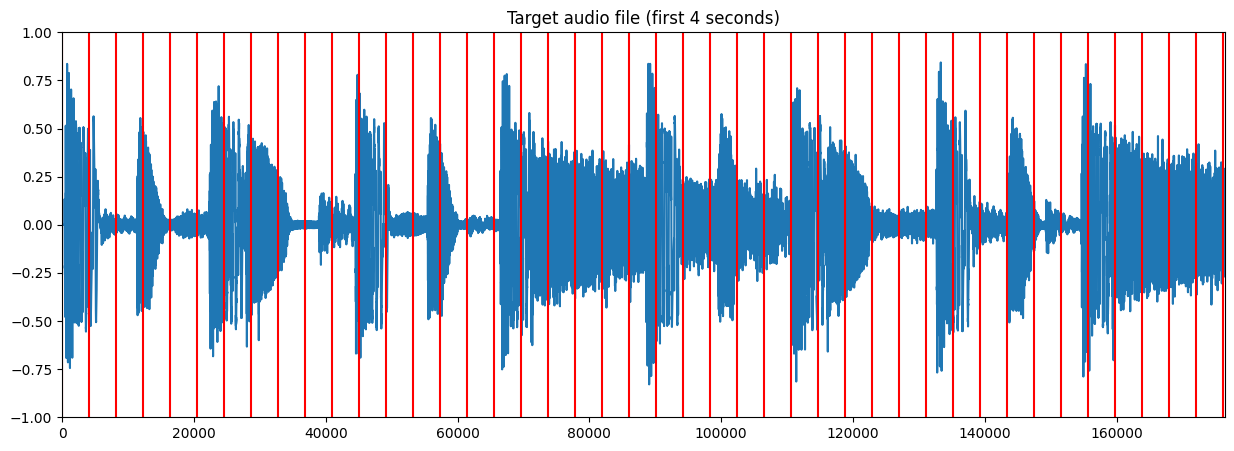

,freesound_id,id,path,start_sample,end_sample,loudness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12
0,None,None_f0,213524__garzul__120-bpm-distorded-drum-loop.wav,0,4096,0.014969,-610.609375,171.386307,19.981266,52.501537,12.665470,14.360901,10.304024,9.495296,-2.387438,10.962349,3.563848,-4.270397,4.410189
1,None,None_f1,213524__garzul__120-bpm-distorded-drum-loop.wav,4096,8192,0.006360,-760.779968,191.833771,15.245850,28.118507,4.100727,16.301195,17.526974,20.067726,10.209145,11.320105,2.673225,-0.605686,10.328053
2,None,None_f2,213524__garzul__120-bpm-distorded-drum-loop.wav,8192,12288,0.002600,-702.196289,35.689728,-17.177423,31.543301,-10.823902,7.278025,-8.849287,9.557550,16.805626,4.518955,7.588467,5.886110,3.015432
3,None,None_f3,213524__garzul__120-bpm-distorded-drum-loop.wav,12288,16384,0.003072,-632.422791,-14.642250,-57.702293,37.183220,-10.008492,14.882113,-6.809162,-4.061150,-5.629520,-10.711342,1.397488,1.584482,-1.667780
4,None,None_f4,213524__garzul__120-bpm-distorded-drum-loop.wav,16384,20480,0.000367,-788.471680,83.742516,-60.763355,2.984604,2.070744,5.210243,-24.195072,-3.615704,7.743675,3.316528,-9.738598,-14.365681,10.865707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,None,None_f81,213524__garzul__120-bpm-distorded-drum-loop.wav,331776,335872,0.014656,-600.834656,160.289993,14.284798,34.750801,7.389053,21.637878,9.320608,16.109562,11.054174,8.395451,2.966875,4.596798,2.262691
82,None,None_f82,213524__garzul__120-bpm-distorded-drum-loop.wav,335872,339968,0.007377,-564.974976,96.105690,-35.898289,-0.893803,-28.646303,-5.862803,1.169773,26.327982,21.833658,11.592173,3.552311,4.013515,-1.871527
83,None,None_f83,213524__garzul__120-bpm-distorded-drum-loop.wav,339968,344064,0.005988,-578.643799,107.279549,-42.246433,-4.723166,-29.391199,-11.231049,-13.430565,14.318197,21.213411,14.903101,0.107481,0.620056,-5.996813
84,None,None_f84,213524__garzul__120-bpm-distorded-drum-loop.wav,344064,348160,0.005655,-596.028320,122.856056,-36.042908,2.336626,-27.216127,-11.551352,-13.302412,12.089512,23.759693,18.790564,2.417025,-2.537495,-5.690636


,start_sample,end_sample,loudness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12
count,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000
mean,174080.000000,178176.000000,0.006218,-643.003845,112.991020,-24.843929,19.499214,-3.362056,10.335670,0.905216,11.547499,10.351719,4.320158,-4.426902,-4.004887,-0.090215
std,102277.046183,102277.046183,0.004499,94.961044,57.407063,25.355984,20.228325,19.722254,16.030066,8.976486,11.612938,9.044253,11.095074,10.915480,8.117366,7.404260
min,0.000000,4096.000000,0.000308,-920.770874,-14.642250,-76.731422,-19.720646,-41.484840,-14.107754,-24.195072,-15.307226,-8.862465,-15.657234,-45.453102,-24.915493,-12.621822
25%,87040.000000,91136.000000,0.002643,-700.569305,78.108446,-41.368792,1.673990,-21.451173,-4.040411,-3.785856,4.450365,4.943749,-2.364730,-11.290137,-8.440696,-5.521977
50%,174080.000000,178176.000000,0.005142,-617.491943,127.579781,-31.839149,15.760599,-3.233306,11.302720,0.576285,12.191217,10.288968,4.051548,-1.684171,-3.445389,-1.346438
75%,261120.000000,265216.000000,0.009551,-569.963303,155.286640,-10.527523,37.001503,12.579768,21.613178,5.596549,20.386654,16.643041,8.821382,3.172264,2.636587,3.485048
max,348160.000000,352256.000000,0.015879,-515.185242,195.265167,25.322575,57.142410,38.377857,40.672310,29.638000,34.052483,30.165390,49.542175,15.581570,10.368275,24.310287


In [ ]:
TARGET_SOUND_PATH = '213524__garzul__120-bpm-distorded-drum-loop.wav'  # Filename of the target audio we'll reconstruct
DATAFRAME_TARGET_FILE_FILENAME = 'dataframe_target.csv'  # DataFrame file where to store the analysis results of the target audio

# Analyze the target audio file and store results in a new DataFrame
print('Analyzing target sound {0}'.format(TARGET_SOUND_PATH))
target_analysis = analyze_sound(TARGET_SOUND_PATH, frame_size=4096, sync_with_beats=False)  # Also split audio in chunks of 8192 samples (~185ms)
df_target = pd.DataFrame(target_analysis)
df_target.to_csv(DATAFRAME_TARGET_FILE_FILENAME)
print('Saved target dataframe with {0} entries! {1}'.format(len(df_target), DATAFRAME_TARGET_FILE_FILENAME))

# Plot target audio file waveform and show ticks at the start samples of the chunks
plt.figure(figsize=(15,5))
audio = estd.MonoLoader(filename=TARGET_SOUND_PATH)()
plt.plot(audio)
plt.vlines(df_target['start_sample'].values, -1, 1, color='red')
plt.axis([0, min(len(audio), 44100 * 4), -1, 1])
plt.title('Target audio file (first 4 seconds)')
plt.show()

display(df_target)  # Show data frame contents
df_target.describe()  # Show statistics of numerical fields in data frame